In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F 
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [2]:
# Create dataset and split into train, val, test 
random.seed(42)
random.shuffle(words)

def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for chr in w + '.':
            ix = stoi[chr]
            X.append(context) 
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words)) 

X_tr, Y_tr = build_dataset(words[:n1])
X_de, Y_de = build_dataset(words[n1:n2])
X_te, Y_te = build_dataset(words[n2:])

print(f"There are {X_tr.shape[0]} training samples")
print(f"There are {X_de.shape[0]} validation samples")
print(f"There are {X_te.shape[0]} testing samples")
print(f"Each input vector has dimension {X_tr.shape[1]} and each output vector has a single dimension")

There are 182625 training samples
There are 22655 validation samples
There are 22866 testing samples
Each input vector has dimension 3 and each output vector has a single dimension


**1. Tune the hyperparameters of the training to beat my best validation loss of 2.2**

The hyperparameters of our network are: 

1. Embedding dimensions 
2. Number of neurons in hidden layer 
3. Learning rate 
4. Activation function
5. Size of mini-batch i.e. number of examples
6. Number of layers
7. Number of training epochs

In the lecture Andrej reduces the validation loss by tweaking the learning rate and the embedding dimensions. 

Experiment results:

- I tried adding another layer to it, but that ended up making performance poorer. I chose not to sit and optimize that larger problem due to time constraints.
- Using an exponential function for the non-linearity makes the loss blow up to $\infty$ since the function blows up to large values as inputs are increased
- I also tried adjusting the learning rate based on the loss, something like "lr = 0.0.1 if loss.item()<=2.2 else 0.0001". But for some reason this leads to very poor optimization and the final loss was horrible.

In [3]:
import torch
import torch.nn.functional as F
import pandas as pd

embedding_dimensions = [5, 10, 20]
results = pd.DataFrame(columns=['embedding size', 'dev loss'])

for dimension in embedding_dimensions:
    g = torch.Generator().manual_seed(2147483647)

    # Parameter initialization
    C = torch.randn((27, dimension), generator=g)
    W1 = torch.randn((dimension * 3, 200), generator=g)
    b1 = torch.randn(200, generator=g)
    W2 = torch.randn((200, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True

    # Training loop
    for i in range(200000):
        ix = torch.randint(0, X_tr.shape[0], (80,))
        emb = C[X_tr[ix]]                             # (80, 3, dimension)
        h = torch.tanh(emb.view(-1, dimension * 3) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_tr[ix])

        for p in parameters:
            p.grad = None
        loss.backward()

        lr = 0.01 if i <= 100000 else 0.001
        for p in parameters:
            p.data += -lr * p.grad

    # Dev loss computation
    emb_de = C[X_de]                                 # (num_dev, 3, dimension)
    h_de = torch.tanh(emb_de.view(-1, dimension * 3) @ W1 + b1)
    logits_de = h_de @ W2 + b2
    loss_de = F.cross_entropy(logits_de, Y_de).item()

    # Store results
    row = pd.DataFrame({'embedding size': [dimension], 'dev loss': [loss_de]})
    results = pd.concat([results, row], ignore_index=True)



C:\Users\srira\AppData\Local\Temp\ipykernel_6284\3066229491.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row], ignore_index=True)


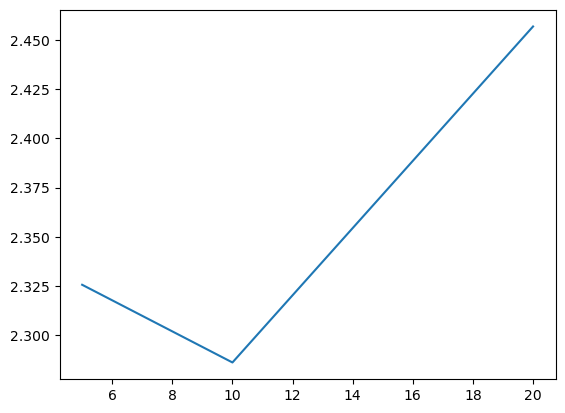

In [4]:
plt.plot(results['embedding size'],results['dev loss']);

In [5]:
import torch
import torch.nn.functional as F
import pandas as pd

neurons = [200, 300, 400]
results = pd.DataFrame(columns=['width', 'dev loss'])

for width in neurons:
    g = torch.Generator().manual_seed(2147483647)

    # Parameter initialization
    C = torch.randn((27, 10), generator=g)
    W1 = torch.randn((30, width), generator=g)
    b1 = torch.randn(width, generator=g)
    W2 = torch.randn((width, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True

    # Training loop
    for i in range(200000):
        ix = torch.randint(0, X_tr.shape[0], (80,))
        emb = C[X_tr[ix]]                              # shape (80, 3, 10)
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)      # collapse to (80, 30)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_tr[ix])

        for p in parameters:
            p.grad = None
        loss.backward()

        lr = 0.01 if i <= 100000 else 0.001
        for p in parameters:
            p.data += -lr * p.grad

    # Dev loss calculation
    emb_de = C[X_de]                                  # shape (dev_size, 3, 10)
    h_de = torch.tanh(emb_de.view(-1, 30) @ W1 + b1)
    logits_de = h_de @ W2 + b2
    loss_de = F.cross_entropy(logits_de, Y_de).item()  # convert to float

    # Save results
    row = pd.DataFrame({'width': [width], 'dev loss': [loss_de]})
    results = pd.concat([results, row], ignore_index=True)


C:\Users\srira\AppData\Local\Temp\ipykernel_6284\4099945594.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row], ignore_index=True)


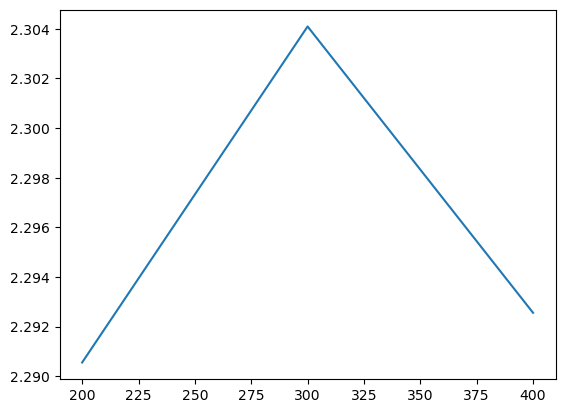

In [6]:
plt.plot(results['width'],results['dev loss']);

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd

mini_batches = [30, 60, 80]
results = pd.DataFrame(columns=['size', 'dev loss'])

for size in mini_batches:
    g = torch.Generator().manual_seed(2147483647)
    
    # Model parameters
    C = torch.randn((27, 10), generator=g)
    W1 = torch.randn((30, 200), generator=g)
    b1 = torch.randn(200, generator=g)
    W2 = torch.randn((200, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True

    # Training loop
    for i in range(200000):
        ix = torch.randint(0, X_tr.shape[0], (size,))

        emb = C[X_tr[ix]]                               # shape: (size, 3, 10)
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)       # shape: (size, 200)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_tr[ix])

        for p in parameters:
            p.grad = None
        loss.backward()

        lr = 0.01 if i <= 100000 else 0.001
        for p in parameters:
            p.data += -lr * p.grad

    # Evaluate on dev set
    emb_de = C[X_de]                                    # shape: (dev_size, 3, 10)
    h_de = torch.tanh(emb_de.view(-1, 30) @ W1 + b1)
    logits_de = h_de @ W2 + b2
    loss_de = F.cross_entropy(logits_de, Y_de).item()   # scalar

    # Store result
    row = pd.DataFrame({'size': [size], 'dev loss': [loss_de]})
    results = pd.concat([results, row], ignore_index=True)

C:\Users\srira\AppData\Local\Temp\ipykernel_6284\459871499.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row], ignore_index=True)


In [ ]:
plt.plot(results['size'],results['dev loss']);

**2. I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?**

Since we have 27 possible characters (alphabet + '.' for end), uniform probability would mean that each character has a 1/27 chance of being next. 

The log liklihood loss is calculated as follows:

Let $x$ be the 27 dimensional output of the network 

1. Compute $e^{i}$, where $i$ is one dimension of the output

2. Normalize the counts, $e^{i} = \frac{e^{i}}{\sum_{j=1}^{27}e^{j}}$. This is the probability for letter $i$ to be next character 

Now, we want it to be the case that $e^{i} = \frac{1}{27}$ for all $i$

Which means, 

$\frac{e^{i}}{27 \cdot e^{i}} = \frac{1}{27}$

Hence, as long as all the counts are the same constant value, we are happy. It doesn't matter which one. 

The loss then will simply be $ -log(\frac{1}{27}) = 3.295$

🚨 The results below are from direct initialization --> prediction on validation set

In [ ]:
# Initializing all values to either 0 or 1 is simplest 
logits_zeros = torch.zeros((X_de.shape[0], 27))
loss_zeroes = F.cross_entropy(logits_zeros, Y_de)

logits_ones = torch.ones((X_de.shape[0], 27))
loss_ones = F.cross_entropy(logits_ones, Y_de)

print(torch.equal(loss_ones, loss_zeroes))
print(loss_ones.item())

True
3.295836925506592


The easy way to initialize would be to just make all the weights the same constant, like 1/0. Same answer as above confirmed. 

Let's instead use some methods from https://en.wikipedia.org/wiki/Weight_initialization 

In particular, I picked Xavier initialization:

Each entry for $W^{l}$ is made from a uniform distribution in the range: $[-U, U]$, where $U = \sqrt{\frac{6}{n_{l}+n_{l+1}}}$

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g) # The embedding matrix can remain random, making it constant doesn't improve a lot
n11, n12 = 30, 200
U1 = (6/(n11+n12)) ** 1/2 
W1 = torch.empty((30, 200)).uniform_(-U1,U1)
B1 = torch.ones(200)
n21, n22 = 200, 27 
U2 = (6/(n21+n22)) ** 1/2
W2 = torch.empty((200, 27)).uniform_(-U2,U2)
B2 = torch.ones(27)

embd = C[X_de]
h = torch.tanh(embd.view(-1,30) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y_de)
print(loss.item())

3.3220431804656982


**3. Read the Bengio et al 2003 paper, implement and try any idea from the paper. Did it work?**